# How To Ensemble OOF
In this notebook, we learn how to use `forward selection` to ensemble OOF. First build lots of models using the same KFolds (i.e. use same `seed`). Next save all the oof files as `oof_XX.csv` and submission files as `sub_XX.csv` where the oof and submission share the same `XX` number. Then save them in a Kaggle dataset and run the code below.

The ensemble begins with the model of highest oof AUC. Next each other model is added one by one to see which additional model increases ensemble AUC the most. The best additional model is kept and the process is repeated until the ensemble AUC doesn't increase.

In [1]:
import pandas as pd, numpy as np, os
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
import pickle
with open('pet/oof.pkl', 'rb') as web:
    pkl = pickle.load(web)

In [48]:
PATH = 'pet/'
FILES = os.listdir(PATH)

OOF = np.sort( [f for f in FILES if 'oof' in f] )
OOF_CSV = [pd.read_csv(PATH+k).sort_values('Id') for k in OOF]

print('We have %i oof files...'%len(OOF))
print(); print(OOF)

We have 12 oof files...

['oof_df_cait.csv' 'oof_df_nfl1.csv' 'oof_df_nfl2.csv'
 'oof_df_swin224crop.csv' 'oof_df_swin348crop.csv'
 'oof_df_vitlsr348crop.csv' 'oof_lgbm_cait384.csv' 'oof_lgbm_nfl1.csv'
 'oof_lgbm_nfl2.csv' 'oof_lgbm_vitlsr384.csv' 'oof_svr_nfl1.csv'
 'oof_svr_nfl2.csv']


In [49]:
def get_score(y_true, y_pred):
    score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
    return score

In [50]:
x = np.zeros(( len(OOF_CSV[0]),len(OOF) ))
for k in range(len(OOF)):
    x[:,k] = OOF_CSV[k].preds.values
    
TRUE = OOF_CSV[0].Pawpularity.values

In [51]:
all = []
for k in range(x.shape[1]):
    #print(OOF_CSV[0].Pawpularity)
    #print(x[:,k])
    auc = get_score(OOF_CSV[0].Pawpularity,x[:,k])
    all.append(auc)
    print('Model %i has OOF RMSE = %.4f'%(k,auc))
    
m = [np.argmax(all)]; w = []

Model 0 has OOF RMSE = 17.8153
Model 1 has OOF RMSE = 18.3068
Model 2 has OOF RMSE = 18.2978
Model 3 has OOF RMSE = 17.6729
Model 4 has OOF RMSE = 17.7839
Model 5 has OOF RMSE = 18.1383
Model 6 has OOF RMSE = 17.7387
Model 7 has OOF RMSE = 17.9953
Model 8 has OOF RMSE = 17.9577
Model 9 has OOF RMSE = 18.0675
Model 10 has OOF RMSE = 18.3607
Model 11 has OOF RMSE = 18.2314


# Build OOF Ensemble. Maximize CV Score

In [52]:
old = np.max(all); 

RES = 200; 
PATIENCE = 10; 
TOL = 0.0003
DUPLICATES = False

print('Ensemble RMSE = %.4f by beginning with model %i'%(old,m[0]))
print()

for kk in range(len(OOF)):
    
    # BUILD CURRENT ENSEMBLE
    md = x[:,m[0]]
    for i,k in enumerate(m[1:]):
        md = w[i]*x[:,k] + (1-w[i])*md
        
    # FIND MODEL TO ADD
    mx = 100; mx_k = 0; mx_w = 0
    print('Searching for best model to add... ')
    
    # TRY ADDING EACH MODEL
    for k in range(x.shape[1]):
        print(k,', ',end='')
        if not DUPLICATES and (k in m): continue
            
        # EVALUATE ADDING MODEL K WITH WEIGHTS W
        bst_j = 0; bst = 100; ct = 0
        for j in range(RES):
            tmp = j/RES*x[:,k] + (1-j/RES)*md
            auc = get_score(TRUE,tmp)
            if auc<bst:
                bst = auc
                bst_j = j/RES
            else: ct += 1
            if ct>PATIENCE: break
        if bst<mx:
            mx = bst
            mx_k = k
            mx_w = bst_j
            
    # STOP IF INCREASE IS LESS THAN TOL
    inc = old-mx
    if inc<=TOL: 
        print(); print('No increase. Stopping.')
        break
        
    # DISPLAY RESULTS
    print(); #print(kk,mx,mx_k,mx_w,'%.5f'%inc)
    print('Ensemble RMSE = %.4f after adding model %i with weight %.3f. Increase of %.4f'%(mx,mx_k,mx_w,inc))
    print()
    
    old = mx; m.append(mx_k); w.append(mx_w)

Ensemble RMSE = 18.3607 by beginning with model 10

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 
Ensemble RMSE = 17.4921 after adding model 3 with weight 0.690. Increase of 0.8686

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 
Ensemble RMSE = 17.4018 after adding model 6 with weight 0.340. Increase of 0.0903

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 
Ensemble RMSE = 17.3777 after adding model 11 with weight 0.140. Increase of 0.0241

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 
Ensemble RMSE = 17.3579 after adding model 4 with weight 0.175. Increase of 0.0198

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 
Ensemble RMSE = 17.3495 after adding model 0 with weight 0.120. Increase of 0.0084

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 
Ensem

In [53]:
print('We are using models',m)
print('with weights',w)
print('and achieve ensemble RMSE = %.4f'%old)

We are using models [10, 3, 6, 11, 4, 0, 5]
with weights [0.69, 0.34, 0.14, 0.175, 0.12, 0.07]
and achieve ensemble RMSE = 17.3449


[30.2983017  44.48873901 36.95105743 ... 24.76463699 40.09108353
 50.179245  ]
[38.074299   42.31146884 40.48928398 ... 25.0719699  45.36662582
 43.38467355]
[40.35985456 44.43308292 40.7767056  ... 26.5153084  46.15165873
 42.70997198]
[38.66189275 45.75354888 40.74251218 ... 27.01512758 45.18490473
 43.55896823]
[39.66178662 44.67832248 39.77443717 ... 26.75404306 44.1343439
 44.21168004]
[39.69323783 44.60145198 39.69311903 ... 27.13698261 44.3984404
 43.63532364]
[39.45708794 44.21734644 40.29210924 ... 26.86669829 44.34672178
 43.36720098]


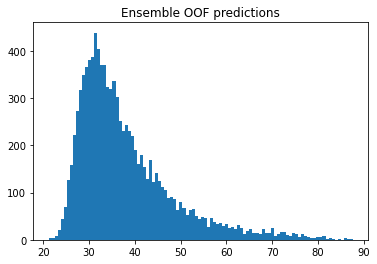

In [54]:
md = x[:,m[0]]
print(md)
for i,k in enumerate(m[1:]):
    md = w[i]*x[:,k] + (1-w[i])*md
    print(md)
plt.hist(md,bins=100)
plt.title('Ensemble OOF predictions')
plt.show()

In [8]:
df = OOF_CSV[0].copy()
df.pred = md
df.to_csv('ensemble_oof.csv',index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


# Load SUB Files

In [9]:
SUB = np.sort( [f for f in FILES if 'sub' in f] )
SUB_CSV = [pd.read_csv(PATH+k) for k in SUB]

print('We have %i submission files...'%len(SUB))
print(); print(SUB)

We have 7 submission files...

['eca_nfnetl0_sub_01.csv' 'eff_b0_ns_sub_06.csv' 'eff_b0_sub_05.csv'
 'eff_b3_ns_sub_07.csv' 'eff_b3_ns_w15_sub_02.csv'
 'eff_b3_ns_w9_sub_04.csv' 'eff_v2_s_sub_03.csv']


In [10]:
# VERFIY THAT SUBMISSION FILES MATCH OOF FILES
a = np.array( [ int( x.split('_')[-1].split('.')[0]) for x in SUB ] )
b = np.array( [ int( x.split('_')[-1].split('.')[0]) for x in OOF ] )
if len(a)!=len(b):
    print('ERROR submission files dont match oof files')
else:
    for k in range(len(a)):
        if a[k]!=b[k]: print('ERROR submission files dont match oof files')

In [11]:
y = np.zeros(( len(SUB_CSV[0]),len(SUB) ))
for k in range(len(SUB)):
    y[:,k] = SUB_CSV[k].target.values

# Build SUB Ensemble

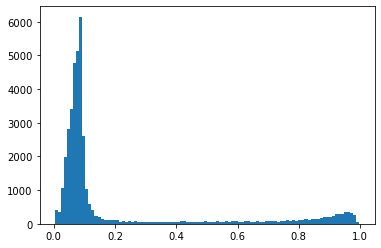

In [12]:
md2 = y[:,m[0]]
for i,k in enumerate(m[1:]):
    md2 = w[i]*y[:,k] + (1-w[i])*md2
plt.hist(md2,bins=100)
plt.show()

In [13]:
df = SUB_CSV[0].copy()
df.target = md2
df.to_csv('ensemble_subv2.csv',index=False)